**Terraformers Data Platform Data Queries**

First, we form a connection to the OLAP Data Warehouse. The wh_connection function accesses AWS Secrets Manager to retrieve the securely held Database credentials, then connects to the DB.

In [ ]:
from lambda3.src.lambda3_connection import wh_connection
from decimal import Decimal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

conn = wh_connection()

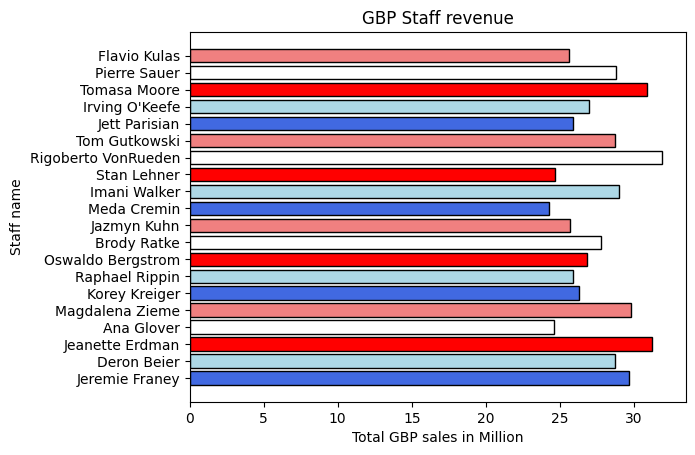

In [138]:
sales_gbp_by_staff_rows = conn.run("""SELECT ROUND((SUM(units_sold * unit_price)/1000000), 1)
                       AS total_mil_gbp_sold, CONCAT (first_name, ' ', last_name) AS staff_name
                       FROM fact_sales_order 
                       JOIN dim_staff
                       ON staff_id = sales_staff_id
                       JOIN dim_currency
                       ON fact_sales_order.currency_id = dim_currency.currency_id
                       WHERE dim_currency.currency_code = 'GBP'
                       GROUP BY staff_id, dim_currency.currency_code;""")
fsales_cols = [col['name'] for col in conn.columns]
gbp_df = pd.DataFrame(sales_gbp_by_staff_rows, columns=fsales_cols)
plt.barh(gbp_df['staff_name'], gbp_df['total_mil_gbp_sold'], color=['royalblue', 'lightblue','red', 'white', 'lightcoral'], edgecolor='black')
plt.xlabel("Total GBP sales in Million")
plt.ylabel("Staff name")
plt.title("GBP Staff revenue")
plt.show()



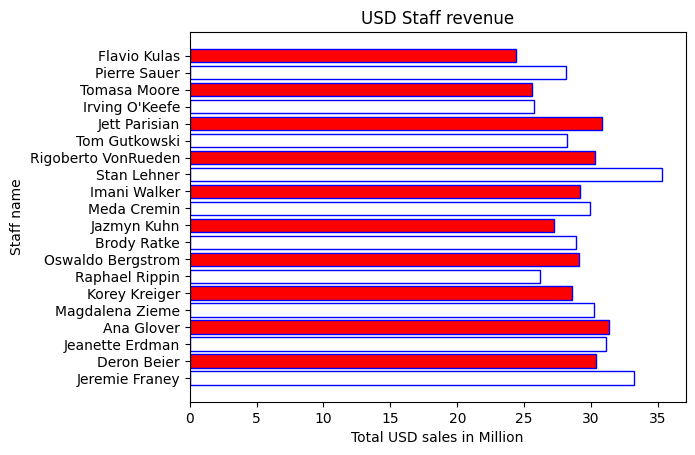

In [141]:
sales_usd_by_staff_rows = conn.run("""SELECT ROUND((SUM(units_sold * unit_price)/1000000), 1)
                       AS total_mil_usd_sold, CONCAT (first_name, ' ', last_name) AS staff_name
                       FROM fact_sales_order 
                       JOIN dim_staff
                       ON staff_id = sales_staff_id
                       JOIN dim_currency
                       ON fact_sales_order.currency_id = dim_currency.currency_id
                       WHERE dim_currency.currency_code = 'USD'
                       GROUP BY staff_id, dim_currency.currency_code;""")
fsales_cols = [col['name'] for col in conn.columns]
usd_df = pd.DataFrame(sales_usd_by_staff_rows, columns=fsales_cols)
plt.barh(usd_df['staff_name'], usd_df['total_mil_usd_sold'], color=['white', 'red'], edgecolor=['blue'])
plt.xlabel("Total USD sales in Million")
plt.ylabel("Staff name")
plt.title("USD Staff revenue")
plt.show()

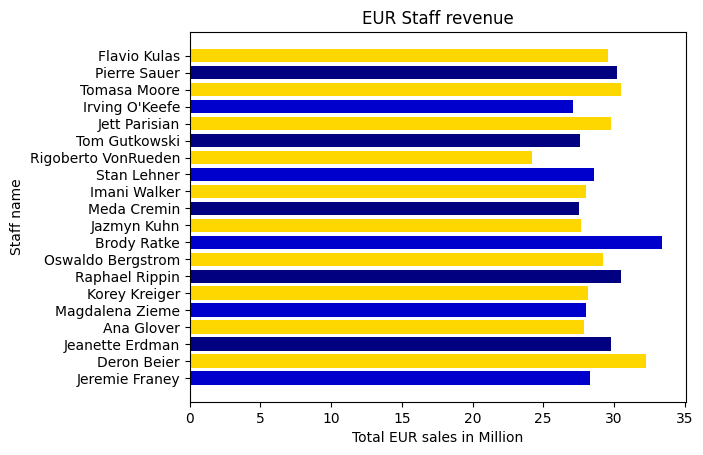

In [136]:
sales_eur_by_staff_rows = conn.run("""SELECT ROUND((SUM(units_sold * unit_price)/1000000), 1)
                       AS total_mil_eur_sold, CONCAT (first_name, ' ', last_name) AS staff_name
                       FROM fact_sales_order 
                       JOIN dim_staff
                       ON staff_id = sales_staff_id
                       JOIN dim_currency
                       ON fact_sales_order.currency_id = dim_currency.currency_id
                       WHERE dim_currency.currency_code = 'EUR'
                       GROUP BY staff_id, dim_currency.currency_code;""")
fsales_cols = [col['name'] for col in conn.columns]
eur_df = pd.DataFrame(sales_eur_by_staff_rows, columns=fsales_cols)
plt.barh(eur_df['staff_name'], eur_df['total_mil_eur_sold'], color=['mediumblue', 'gold','navy', 'gold'])
plt.xlabel("Total EUR sales in Million")
plt.ylabel("Staff name")
plt.title("EUR Staff revenue")
plt.show()

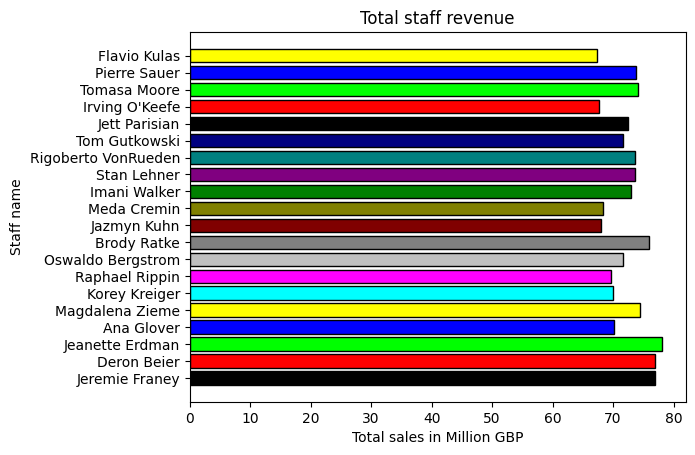

In [145]:
merged = gbp_df.merge(usd_df, how='inner', on='staff_name')
eur_merged = merged.merge(eur_df, how='inner', on='staff_name')
eur_merged['usd_in_gbp'] = eur_merged['total_mil_usd_sold'] * Decimal(0.74)
eur_merged['eur_in_gbp'] = eur_merged['total_mil_eur_sold'] * Decimal(0.8)
eur_merged['total_sold_all_currencies_into_gbp'] = eur_merged['usd_in_gbp'] + eur_merged['total_mil_gbp_sold'] + eur_merged['eur_in_gbp']
eur_merged['total_sold'] = eur_merged['total_sold_all_currencies_into_gbp'].astype('float').round(1)
final_df = eur_merged[['staff_name', 'total_sold']]
plt.barh(final_df['staff_name'], final_df['total_sold'], color=list({
    'Black': (0, 0, 0),
    'Red': (255, 0, 0),
    'Lime': (0, 255, 0),
    'Blue': (0, 0, 255),
    'Yellow': (255 ,255, 0),
    'Cyan': (0, 255, 255),
    'Fuchsia': (255, 0, 255),
    'Silver': (192, 192, 192),
    'Gray': (128, 128, 128),
    'Maroon': (128, 0, 0),
    'Olive': (128, 128, 0),
    'Green': (0, 128, 0),
    'Purple': (128, 0, 128),
    'Teal': (0, 128, 128),
    'Navy': (0, 0, 128),
}.keys()), edgecolor='black')
plt.xlabel("Total sales in Million GBP")
plt.ylabel("Staff name")
plt.title("Total staff revenue")
plt.show()








In [152]:
final_df.loc[final_df['total_sold'].idxmax()]

staff_name    Jeanette Erdman
total_sold               78.1
Name: 2, dtype: object

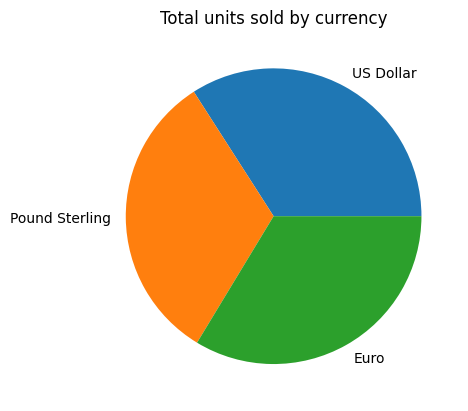

In [ ]:
currency_rows = conn.run("""SELECT SUM(units_sold) AS total_units_sold,
                         currency_name
                         FROM dim_currency
                         JOIN fact_sales_order
                         ON fact_sales_order.currency_id = dim_currency.currency_id
                         GROUP BY currency_name;""")
currency_cols = [col['name'] for col in conn.columns]
currency_df = pd.DataFrame(currency_rows, columns=currency_cols)
currency_df
plt.pie(currency_df['total_units_sold'], labels=currency_df['currency_name'])
plt.title("Total units sold by currency")
plt.show()

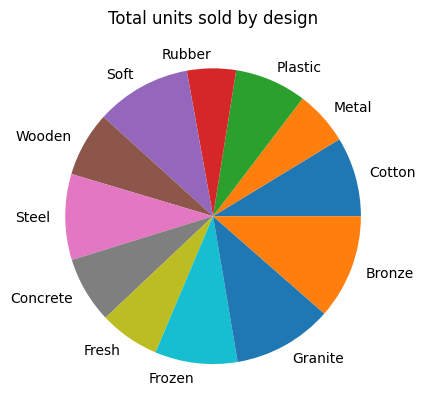

In [162]:
design_rows = conn.run("""SELECT SUM(units_sold) AS total_units_sold,
                         design_name
                         FROM dim_design
                         JOIN fact_sales_order
                         ON fact_sales_order.design_id = dim_design.design_id
                         GROUP BY design_name;""")
design_cols = [col['name'] for col in conn.columns]
design_df = pd.DataFrame(design_rows, columns=design_cols)
design_df
plt.pie(design_df['total_units_sold'], labels=design_df['design_name'])
plt.title("Total units sold by design")
plt.show()

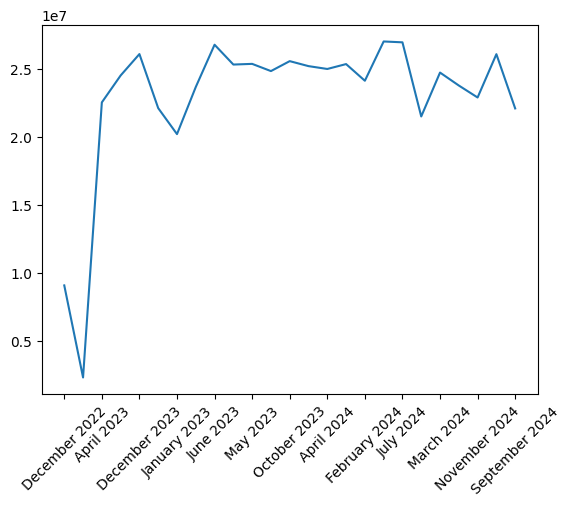

In [ ]:
time_rows = conn.run("""SELECT SUM(units_sold) AS total_units_sold,
                         CONCAT(month_name, ' ', year) AS month
                         FROM dim_date
                         JOIN fact_sales_order
                         ON fact_sales_order.created_date = dim_date.date_id
                         GROUP BY month, month_name, year
                     ORDER BY year, month;""")
time_cols = [col['name'] for col in conn.columns]
time_df = pd.DataFrame(time_rows, columns=time_cols)
plt.plot(time_df['month'], time_df['total_units_sold'])
plt.xticks(ticks=list(range(0,len(time_df), 2)), rotation=45)
plt.show()

In [ ]:
time_rows = conn.run("""SELECT SUM(units_sold) AS total_units_sold,
                         CONCAT(month_name, ' ', year) AS month,
                     design_name AS design
                         FROM dim_date
                         JOIN fact_sales_order
                         ON fact_sales_order.created_date = dim_date.date_id
                     JOIN dim_design
                     ON fact_sales_order.design_id = dim_design.design_id
                         GROUP BY month, month_name, year
                     ORDER BY year, month;""")
time_cols = [col['name'] for col in conn.columns]
time_df = pd.DataFrame(time_rows, columns=time_cols)


,total_mil_gbp_sold,staff_name,total_mil_usd_sold,total_mil_eur_sold,usd_in_gbp,eur_in_gbp,total_sold_all_currencies_into_gbp,total_sold
0,29.7,Jeremie Franey,33.2,28.3,24.56799999999999970512476466,22.64000000000000125677246388,76.90800000000000096189722854,76.9
1,28.7,Deron Beier,30.4,32.3,22.49599999999999972999376041,25.84000000000000143440814782,77.03600000000000116440190823,77.0
2,31.2,Jeanette Erdman,31.1,29.8,23.01399999999999972377651147,23.84000000000000132338584535,78.05400000000000104716235682,78.1
3,24.6,Ana Glover,31.3,27.9,23.16199999999999972200015463,22.32000000000000123900889548,70.08200000000000096100905011,70.1
4,29.8,Magdalena Zieme,30.2,28.0,22.34799999999999973177011725,22.40000000000000124344978758,74.54800000000000097521990483,74.5
5,26.3,Korey Kreiger,28.6,28.2,21.16399999999999974598097197,22.56000000000000125233157178,70.02400000000000099831254375,70.0
6,25.9,Raphael Rippin,26.2,30.5,19.38799999999999976729725404,24.40000000000000135447209004,69.68800000000000112176934408,69.7
7,26.8,Oswaldo Bergstrom,29.1,29.2,21.53399999999999974154007987,23.36000000000000129674049276,71.69400000000000103828057263,71.7
8,27.8,Brody Ratke,28.9,33.4,21.38599999999999974331643671,26.72000000000000148325796090,75.90600000000000122657439761,75.9
9,25.7,Jazmyn Kuhn,27.2,27.7,20.12799999999999975841546984,22.16000000000000123012711128,67.98800000000000098854258112,68.0


In [ ]:
eur_merged

,total_mil_gbp_sold,staff_name,total_mil_usd_sold,total_mil_eur_sold,usd_in_gbp,eur_in_gbp
0,29.7,Jeremie Franey,33.2,28.3,24.56799999999999970512476466,22.64000000000000125677246388
1,28.7,Deron Beier,30.4,32.3,22.49599999999999972999376041,25.84000000000000143440814782
2,31.2,Jeanette Erdman,31.1,29.8,23.01399999999999972377651147,23.84000000000000132338584535
3,24.6,Ana Glover,31.3,27.9,23.16199999999999972200015463,22.32000000000000123900889548
4,29.8,Magdalena Zieme,30.2,28.0,22.34799999999999973177011725,22.40000000000000124344978758
5,26.3,Korey Kreiger,28.6,28.2,21.16399999999999974598097197,22.56000000000000125233157178
6,25.9,Raphael Rippin,26.2,30.3,19.38799999999999976729725404,24.24000000000000134559030585
7,26.8,Oswaldo Bergstrom,29.1,29.2,21.53399999999999974154007987,23.36000000000000129674049276
8,27.8,Brody Ratke,28.9,33.4,21.38599999999999974331643671,26.72000000000000148325796090
9,25.7,Jazmyn Kuhn,27.2,27.7,20.12799999999999975841546984,22.16000000000000123012711128


KeyError: "['total_sold_all_currencies_into_gbp'] not found in axis"

In [ ]:
eur_merged

,total_mil_gbp_sold,staff_name,total_mil_usd_sold,total_mil_eur_sold,usd_in_gbp,eur_in_gbp,total_sold_all_currencies_into_gbp
0,29.7,Jeremie Franey,33.2,28.3,24.56799999999999970512476466,22.64000000000000125677246388,76.90800000000000096189722854
1,28.7,Deron Beier,30.4,32.3,22.49599999999999972999376041,25.84000000000000143440814782,77.03600000000000116440190823
2,31.2,Jeanette Erdman,31.1,29.8,23.01399999999999972377651147,23.84000000000000132338584535,78.05400000000000104716235682
3,24.6,Ana Glover,31.3,27.9,23.16199999999999972200015463,22.32000000000000123900889548,70.08200000000000096100905011
4,29.8,Magdalena Zieme,30.2,28.0,22.34799999999999973177011725,22.40000000000000124344978758,74.54800000000000097521990483
5,26.3,Korey Kreiger,28.6,28.2,21.16399999999999974598097197,22.56000000000000125233157178,70.02400000000000099831254375
6,25.9,Raphael Rippin,26.2,30.3,19.38799999999999976729725404,24.24000000000000134559030585,69.52800000000000111288755989
7,26.8,Oswaldo Bergstrom,29.1,29.2,21.53399999999999974154007987,23.36000000000000129674049276,71.69400000000000103828057263
8,27.8,Brody Ratke,28.9,33.4,21.38599999999999974331643671,26.72000000000000148325796090,75.90600000000000122657439761
9,25.7,Jazmyn Kuhn,27.2,27.7,20.12799999999999975841546984,22.16000000000000123012711128,67.98800000000000098854258112


In [113]:
eur_merged

,total_mil_gbp_sold,staff_name,total_mil_usd_sold,total_mil_eur_sold,usd_in_gbp,eur_in_gbp,total_sold_all_currencies_into_gbp,total_sold
0,29.7,Jeremie Franey,33.2,28.3,24.56799999999999970512476466,22.64000000000000125677246388,76.90800000000000096189722854,76.9
1,28.7,Deron Beier,30.4,32.3,22.49599999999999972999376041,25.84000000000000143440814782,77.03600000000000116440190823,77.0
2,31.2,Jeanette Erdman,31.1,29.8,23.01399999999999972377651147,23.84000000000000132338584535,78.05400000000000104716235682,78.1
3,24.6,Ana Glover,31.3,27.9,23.16199999999999972200015463,22.32000000000000123900889548,70.08200000000000096100905011,70.1
4,29.8,Magdalena Zieme,30.2,28.0,22.34799999999999973177011725,22.40000000000000124344978758,74.54800000000000097521990483,74.5
5,26.3,Korey Kreiger,28.6,28.2,21.16399999999999974598097197,22.56000000000000125233157178,70.02400000000000099831254375,70.0
6,25.9,Raphael Rippin,26.2,30.3,19.38799999999999976729725404,24.24000000000000134559030585,69.52800000000000111288755989,69.5
7,26.8,Oswaldo Bergstrom,29.1,29.2,21.53399999999999974154007987,23.36000000000000129674049276,71.69400000000000103828057263,71.7
8,27.8,Brody Ratke,28.9,33.4,21.38599999999999974331643671,26.72000000000000148325796090,75.90600000000000122657439761,75.9
9,25.7,Jazmyn Kuhn,27.2,27.7,20.12799999999999975841546984,22.16000000000000123012711128,67.98800000000000098854258112,68.0


In [ ]:
final_df

,staff_name,total_sold
0,Jeremie Franey,76.9
1,Deron Beier,77.0
2,Jeanette Erdman,78.1
3,Ana Glover,70.1
4,Magdalena Zieme,74.5
5,Korey Kreiger,70.0
6,Raphael Rippin,69.5
7,Oswaldo Bergstrom,71.7
8,Brody Ratke,75.9
9,Jazmyn Kuhn,68.0


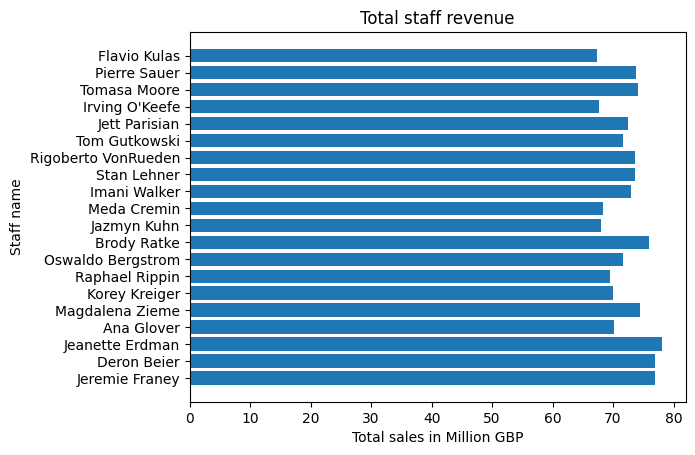